<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#P-Value-calculation" data-toc-modified-id="P-Value-calculation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>P-Value calculation</a></span></li><li><span><a href="#Metric-charts" data-toc-modified-id="Metric-charts-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Metric charts</a></span></li><li><span><a href="#Other-method" data-toc-modified-id="Other-method-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Other method</a></span></li></ul></div>

# T-Test Post-hoc model comparison

## P-Value calculation

In [1]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2e' % x)

In [2]:
df_aug = pd.read_csv('AUG.tsv', sep='\t').set_index('Model')
df_aug.columns

Index(['mse_mean', 'mse_std', 'dssim_mean', 'dssim_std', 'psnr_mean',
       'psnr_std'],
      dtype='object')

**4824 is the nmber of samples in the Test Set**

In [3]:
from scipy.stats import t, sem
import numpy as np
# function for calculating the t-test for two independent samples
def independent_ttest(m1, std1, m2, std2, alpha):
    mean1, mean2 = m1, m2
    # calculate standard errors
    se1, se2 = std1/np.sqrt(4824), std2/np.sqrt(4824)
    # standard error on the difference between the samples
    sed = np.sqrt(se1**2.0 + se2**2.0)
    # calculate the t statistic
    t_stat = (mean1 - mean2) / sed
    # degrees of freedom
    df = 4824*2-2
    # calculate the critical value
    cv = t.ppf(1.0 - alpha, df)
    # calculate the p-value
    p = (1.0 - t.cdf(abs(t_stat), df)) * 2.0
    # return everything
    return t_stat, df, cv, p

In [4]:
def get_comparison(df_result, metric):
    
    df_ttest = pd.DataFrame(np.ones((len(df_result), len(df_result)))*5,
                                    columns = df_result.sort_values(metric+'_mean').index.values,
                                    index=df_result.sort_values(metric+'_mean').index.values
                                   )
    
    for i in df_result.iterrows():
        model1 = i[0]
        mean1 = i[1][metric+'_mean']
        std1 = i[1][metric+'_std']
        for j in df_result.iterrows():
            model2 = j[0]
            mean2 = j[1][metric+'_mean']
            std2 = j[1][metric+'_std']
            df_ttest.loc[model1, model2]=independent_ttest(mean1,std1,
                                                           mean2,std2,
                                                           0.05
                                                          )[3]
    return df_ttest

In [5]:
df_mse_pval = get_comparison(df_aug, 'mse')
df_dssim_pval = get_comparison(df_aug, 'dssim')
df_psnr_pval = get_comparison(df_aug, 'psnr')

In [6]:
import seaborn as sns
from copy import deepcopy

In [7]:
def filter_df(df_in):
    def change_names(df):
        cols = {col:i for i,col in enumerate(df.columns)}
        idxs = {col:'('+str(i)+') '+ col for i,col in enumerate(df.columns)}
        return df.rename(columns=cols, index=idxs)
    df = deepcopy(df_in)
    df[df>0.1]=4
    df[(df<0.1)&(df>0.05)]=3
    df[(df<0.05)&(df>0.02)]=2
    df[(df<0.02)&(df>0)]=1
    return change_names(df)

In [8]:
mask = np.zeros_like(df_mse_pval)
mask[np.triu_indices_from(mask)] = True
mask[np.diag_indices_from(mask)] = False

In [9]:
import matplotlib.pyplot as plt

<AxesSubplot:>

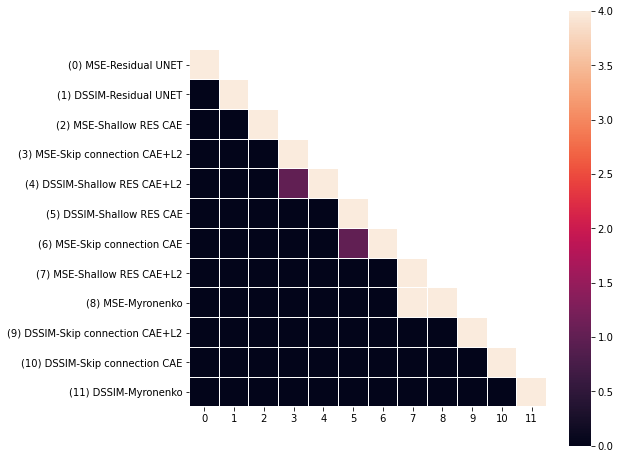

In [10]:
fig = plt.figure(figsize=(8,8))
fig.set_facecolor("white") 
sns.heatmap(filter_df(df_mse_pval), linewidths=.01, mask=mask, square=True, label='big')

<AxesSubplot:>

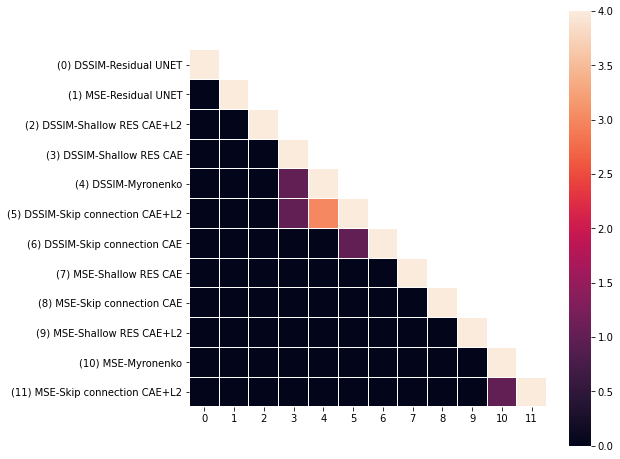

In [11]:
fig = plt.figure(figsize=(8,8))
fig.set_facecolor("white") 
sns.heatmap(filter_df(df_dssim_pval), linewidths=.01, mask=mask, square=True, label='big')

<AxesSubplot:>

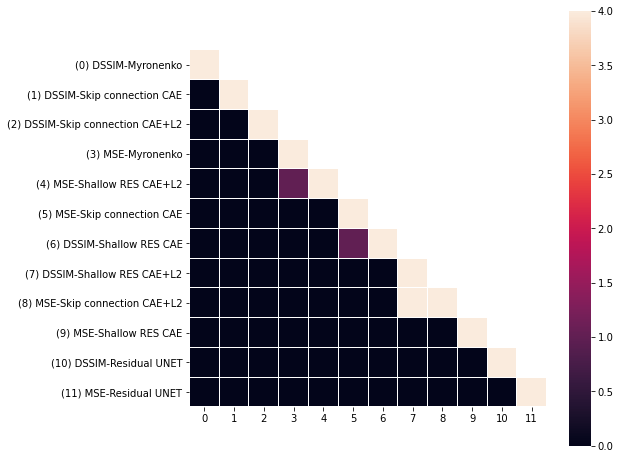

In [12]:
fig = plt.figure(figsize=(8,8))
fig.set_facecolor("white") 
sns.heatmap(filter_df(df_psnr_pval), linewidths=.01, mask=mask, square=True, label='big')

## Metric charts

<AxesSubplot:title={'center':'MSE'}, ylabel='Model'>

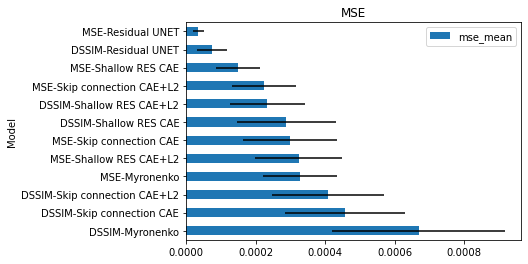

In [13]:
df_aug.sort_values('mse_mean', ascending = False)[['mse_mean', 'mse_std']].plot(kind='barh',
                                                                                xerr='mse_std',
                                                                                title='MSE'
                                                                               )

<AxesSubplot:title={'center':'DSSIM'}, ylabel='Model'>

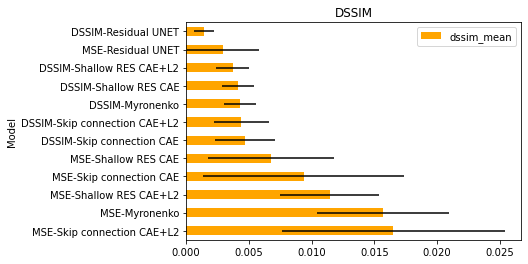

In [14]:
df_aug.sort_values('dssim_mean', ascending = False)[['dssim_mean', 'dssim_std']].plot(kind='barh', 
                                                                                      xerr='dssim_std', 
                                                                                      color='orange', 
                                                                                      title='DSSIM')

<AxesSubplot:title={'center':'PSNR'}, ylabel='Model'>

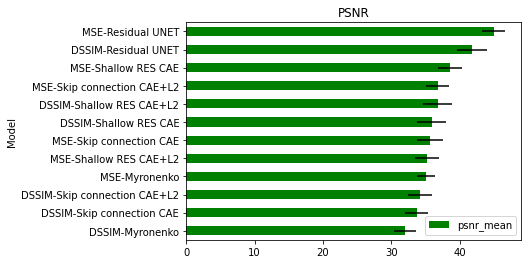

In [15]:
df_aug.sort_values('psnr_mean', ascending = True)[['psnr_mean', 'psnr_std']].plot(kind='barh', 
                                                                                      xerr='psnr_std', 
                                                                                      color='green', 
                                                                                      title='PSNR',
                                                                                      )

## Other method

In [16]:
import glob
import os
import tensorflow as tf
from my_tf_data_loader_optimized import tf_data_png_loader
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [24]:
TEST_img_PATH = '..'+os.path.sep+'IXI-T1'+os.path.sep+'PNG'+os.path.sep+'test_folder'+os.path.sep+'test'
test_img_files = glob.glob(TEST_img_PATH+os.path.sep+'*.png')

models_folders_paths = glob.glob('results/Data_Aug/dssim/*')
models_folders_paths  = [mf for mf in models_folders_paths if 'qualitative' not in mf]
models_folders_paths.extend([mf for mf in glob.glob('results/Data_Aug/mse/*') if 'qualitative' not in mf])

In [25]:
models_folders_paths

['results/Data_Aug/dssim\\myronenko_cae_DSSIM_AUG_NoKReg_LRPlat_T01_12_20__14_06',
 'results/Data_Aug/dssim\\res_skip_cae_DSSIM_AUG_NoKReg_LRPlat_T02_12_20__13_20',
 'results/Data_Aug/dssim\\skip_con_cae_DSSIM_AUG_L2KReg_LRPlat_T02_12_20__09_55',
 'results/Data_Aug/dssim\\skip_con_cae_DSSIM_AUG_NoKReg_LRPlat_T01_12_20__13_21',
 'results/Data_Aug/dssim\\small_res_cae_DSSIM_full_pre_AUG_L2KReg_LRPlat_T01_12_20__16_53',
 'results/Data_Aug/dssim\\small_res_cae_DSSIM_full_pre_AUG_NoKReg_LRPlat_T01_12_20__12_03',
 'results/Data_Aug/mse\\myronenko_cae_MSE_AUG_NoKReg_LRPlat_T01_12_20__10_15',
 'results/Data_Aug/mse\\res_skip_cae_MSE_AUG_NoKReg_LRPlat_T02_12_20__11_47',
 'results/Data_Aug/mse\\res_skip_cae_MSE_DoubleAUG_NoKReg_LRPlat_T02_12_20__20_45',
 'results/Data_Aug/mse\\skip_con_cae_MSE_AUG_L2KReg_LRPlat_T01_12_20__18_23',
 'results/Data_Aug/mse\\skip_con_cae_MSE_AUG_NoKReg_LRPlat_T01_12_20__09_33',
 'results/Data_Aug/mse\\small_res_cae_MSE_full_pre_AUG_L2KReg_LRPlat_T30_11_20__20_04',
 '

In [26]:
test_ds = tf_data_png_loader(test_img_files,
                                  batch_size=8,
                                  resize=(128,128),
                                  train=False,
                                 ).get_tf_ds_generator()

def _dssim( x, y):
        """
        We calculate the Structural Dissimilarity between 2 images.
        """
        return tf.math.divide(tf.subtract(1,tf.image.ssim(x, y, max_val=1.0)), 2)

def _psnr(x, y):
    return tf.image.psnr(x, y, max_val=1.0)

def _mserror( x, y):
    return tf.math.reduce_mean(tf.keras.losses.MSE(x, y))


In [27]:
custom_evaluation = dict()
for model_folder in models_folders_paths:
    model_path = glob.glob(model_folder+'\\*.h5')[0]
    model = tf.keras.models.load_model(model_path, custom_objects = {'DSSIM':_dssim,
                                                                   'PSNR':_psnr
                                                                   }
                                    )
    model_name = model_path.split('\\')[-1][:-3]
    print(model_name, end=' - ')

    #get predicted images
    predicted = model.predict(test_ds)
    i=0
    mse_metrics = []
    dssim_metrics = []
    psnr_metrics = []
    for batchx, batchy in test_ds:
        for x,y in zip(batchx, batchy):
            mse_metrics.append(_mserror(y, predicted[i]).numpy())
            dssim_metrics.append(_dssim(y, predicted[i]).numpy())
            psnr_metrics.append(_psnr(y, predicted[i]).numpy())
            i+=1

    custom_evaluation[model_name] = dict()
    custom_evaluation[model_name]['mses'] = mse_metrics
    custom_evaluation[model_name]['mse_mean'] = mean_mse = np.mean(mse_metrics)
    custom_evaluation[model_name]['mse_std'] = std_mse = np.std(mse_metrics)

    custom_evaluation[model_name]['dssims'] = dssim_metrics
    custom_evaluation[model_name]['dssim_mean'] = mean_dssim = np.mean(dssim_metrics)
    custom_evaluation[model_name]['dssim_std'] = std_dssim = np.std(dssim_metrics)

    custom_evaluation[model_name]['psnrs'] = psnr_metrics
    custom_evaluation[model_name]['psnr_mean'] = mean_psnr = np.mean(psnr_metrics)
    custom_evaluation[model_name]['psnr_std'] = std_psnr =np.std(psnr_metrics)
    
    print( "MSE: {:.2e}+-{:.2e} - DSSIM: {:.2e}+-{:.2e} - PSNR: {:.2e}+-{:.2e}".format(mean_mse, std_mse,
                                                                                            mean_dssim, std_dssim,
                                                                                            mean_psnr, std_psnr
                                                                                            ))
    print()



myronenko_cae_DSSIM_AUG_NoKReg_LRPlat - MSE: 6.69e-04+-2.49e-04 - DSSIM: 4.31e-03+-1.28e-03 - PSNR: 3.20e+01+-1.64e+00

res_skip_cae_DSSIM_AUG_NoKReg_LRPlat - MSE: 7.50e-05+-4.26e-05 - DSSIM: 1.44e-03+-7.95e-04 - PSNR: 4.18e+01+-2.15e+00

skip_con_cae_DSSIM_AUG_L2KReg_LRPlat - MSE: 4.08e-04+-1.61e-04 - DSSIM: 4.38e-03+-2.20e-03 - PSNR: 3.42e+01+-1.72e+00

skip_con_cae_DSSIM_AUG_NoKReg_LRPlat - MSE: 4.57e-04+-1.73e-04 - DSSIM: 4.71e-03+-2.40e-03 - PSNR: 3.37e+01+-1.69e+00

small_res_cae_DSSIM_full_pre_AUG_L2KReg_LRPlat - MSE: 2.34e-04+-1.09e-04 - DSSIM: 3.70e-03+-1.29e-03 - PSNR: 3.68e+01+-2.08e+00

small_res_cae_DSSIM_full_pre_AUG_NoKReg_LRPlat - MSE: 2.88e-04+-1.42e-04 - DSSIM: 4.14e-03+-1.28e-03 - PSNR: 3.59e+01+-2.13e+00

myronenko_cae_MSE_AUG_NoKReg_LRPlat - MSE: 3.27e-04+-1.06e-04 - DSSIM: 1.57e-02+-5.29e-03 - PSNR: 3.51e+01+-1.38e+00

res_skip_cae_MSE_AUG_NoKReg_LRPlat - MSE: 3.44e-05+-1.62e-05 - DSSIM: 2.95e-03+-2.86e-03 - PSNR: 4.50e+01+-1.67e+00

res_skip_cae_MSE_DoubleAUG_NoK

In [45]:
import pickle

with open('individual_metrics.pickle', 'wb') as handle:
    pickle.dump(custom_evaluation, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [50]:
len(custom_evaluation.keys())

13

In [57]:
DF_EVERY_IMAGE = pd.DataFrame.from_dict(custom_evaluation, orient='index')
DF_EVERY_IMAGE = DF_EVERY_IMAGE.drop('res_skip_cae_MSE_DoubleAUG_NoKReg_LRPlat')
len(DF_EVERY_IMAGE)

12

In [58]:
# function for calculating the t-test for two dependent samples
def dependent_ttest(data1, data2, alpha):
    # calculate means
    mean1, mean2 = np.mean(data1), np.mean(data2)
    # number of paired samples
    n = len(data1)
    # sum squared difference between observations
    d1 = np.sum([(data1[i]-data2[i])**2 for i in range(n)])
    # sum difference between observations
    d2 = np.sum([data1[i]-data2[i] for i in range(n)])
    # standard deviation of the difference between means
    sd = np.sqrt((d1 - (d2**2 / n)) / (n - 1))
    # standard error of the difference between the means
    sed = sd / np.sqrt(n)
    # calculate the t statistic
    t_stat = (mean1 - mean2) / sed
    # degrees of freedom
    df = n - 1
    # calculate the critical value
    cv = t.ppf(1.0 - alpha, df)
    # calculate the p-value
    p = (1.0 - t.cdf(abs(t_stat), df)) * 2.0
    # return everything
    return t_stat, df, cv, p

In [61]:
def get_dep_comparison(df_result, metric):
    
    df_ttest = pd.DataFrame(np.ones((len(df_result), len(df_result)))*5,
                                    columns = df_result.sort_values(metric+'_mean').index.values,
                                    index=df_result.sort_values(metric+'_mean').index.values
                                   )
    
    for i in df_result.iterrows():
        model1 = i[0]
        metrics1 = i[1][metric+'s']
        for j in df_result.iterrows():
            model2 = j[0]
            metrics2 = j[1][metric+'s']
            df_ttest.loc[model1, model2]=dependent_ttest(metrics1, metrics2,0.05)[3]
    return df_ttest

In [78]:
df_dep_mse_pval = get_dep_comparison(DF_EVERY_IMAGE, 'mse')
df_dep_mse_pval[np.isnan(df_dep_mse_pval)]=1

df_dep_dssim_pval = get_dep_comparison(DF_EVERY_IMAGE, 'dssim')
df_dep_dssim_pval[np.isnan(df_dep_dssim_pval)]=1

df_dep_psnr_pval = get_dep_comparison(DF_EVERY_IMAGE, 'psnr')
df_dep_psnr_pval[np.isnan(df_dep_psnr_pval)]=1

c:\users\usuario\.conda\envs\d_mri_autoencoder\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


<AxesSubplot:title={'center':'DSSIM'}>

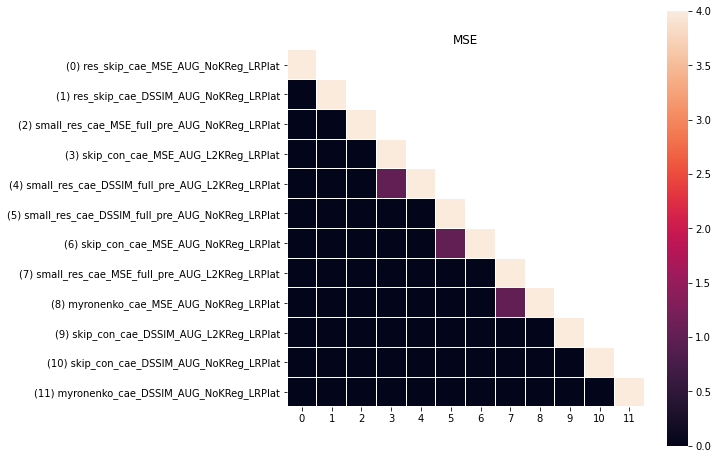

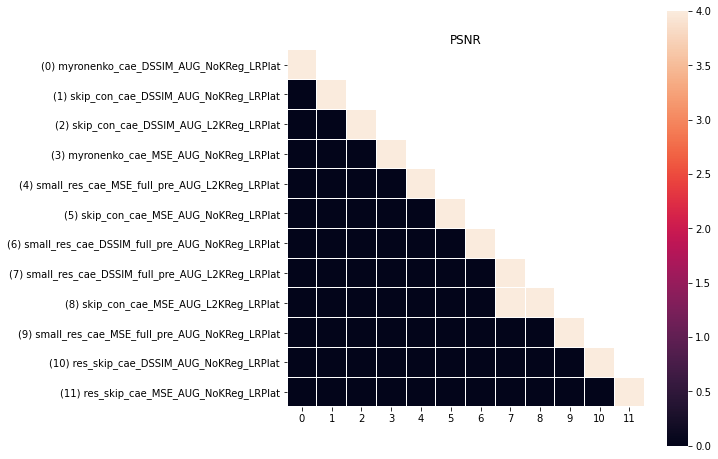

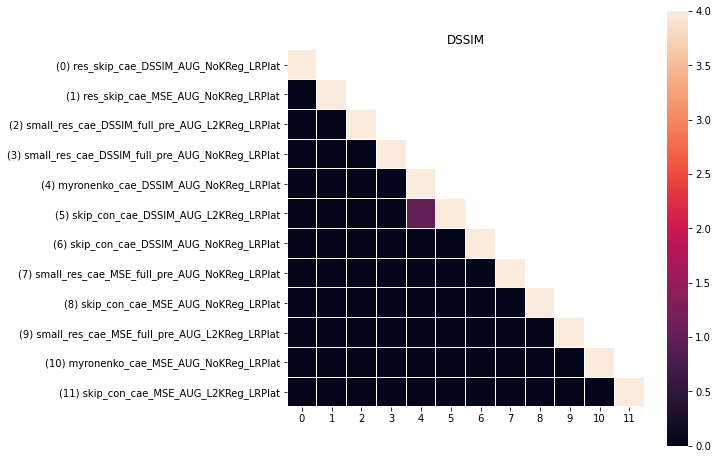

In [85]:
fig = plt.figure(figsize=(8,8))
fig.set_facecolor("white") 
plt.title('MSE')
sns.heatmap(filter_df(df_dep_mse_pval), linewidths=.01, mask=mask, square=True, label='big')

fig = plt.figure(figsize=(8,8))
fig.set_facecolor("white") 
plt.title('PSNR')
sns.heatmap(filter_df(df_dep_psnr_pval), linewidths=.01, mask=mask, square=True, label='big')

fig = plt.figure(figsize=(8,8))
fig.set_facecolor("white") 
plt.title('DSSIM')
sns.heatmap(filter_df(df_dep_dssim_pval), linewidths=.01, mask=mask, square=True, label='big')

<AxesSubplot:title={'center':'DSSIM'}>

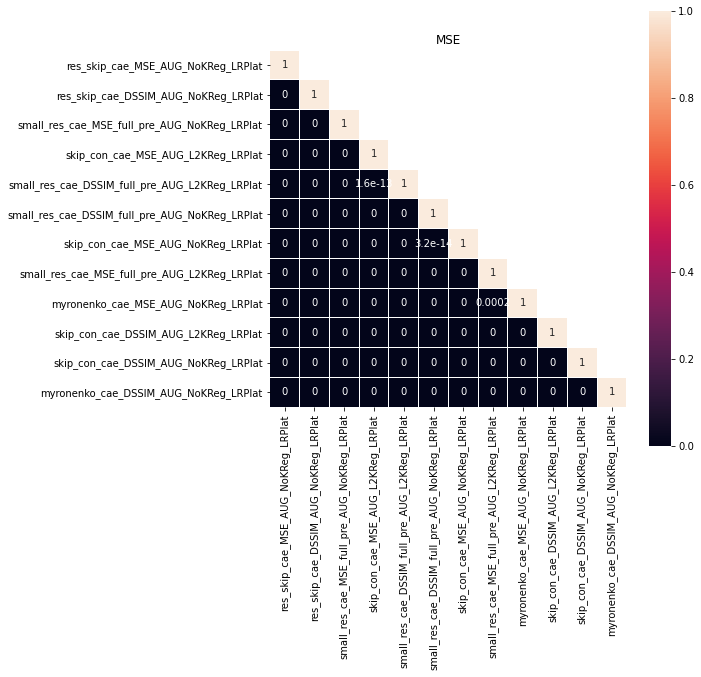

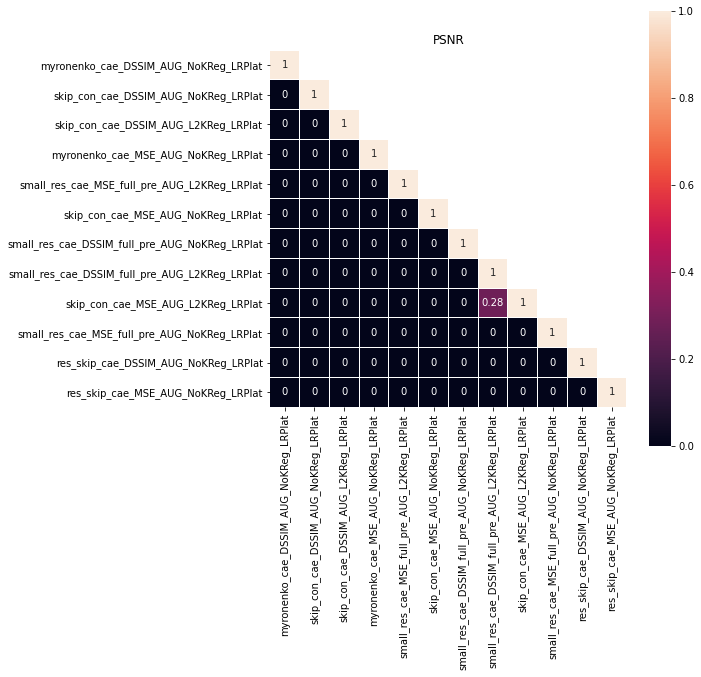

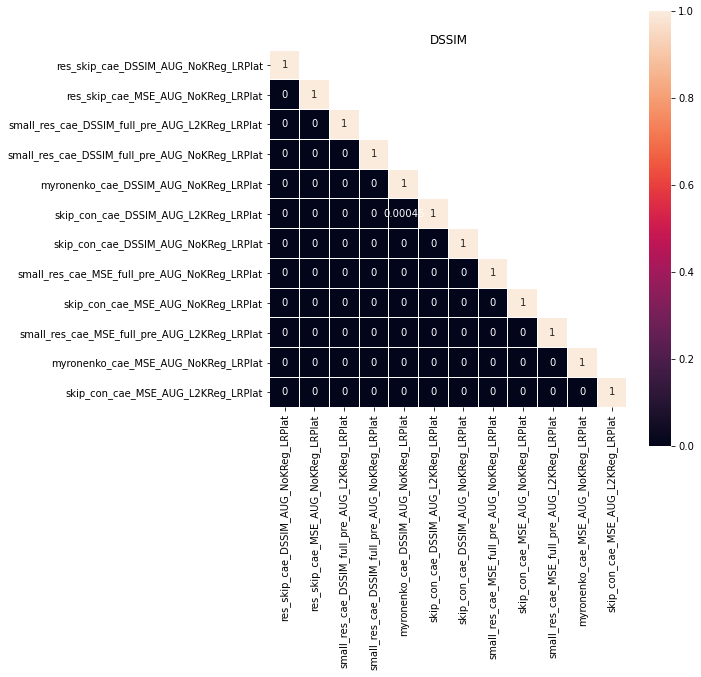

In [86]:
fig = plt.figure(figsize=(8,8))
fig.set_facecolor("white") 
plt.title('MSE')
sns.heatmap(df_dep_mse_pval, linewidths=.01, mask=mask, square=True, label='big', annot=True)

fig = plt.figure(figsize=(8,8))
fig.set_facecolor("white") 
plt.title('PSNR')
sns.heatmap(df_dep_psnr_pval, linewidths=.01, mask=mask, square=True, label='big',annot=True)

fig = plt.figure(figsize=(8,8))
fig.set_facecolor("white") 
plt.title('DSSIM')
sns.heatmap(df_dep_dssim_pval, linewidths=.01, mask=mask, square=True, label='big',annot=True)

In [ ]:
fig = plt.figure(figsize=(8,8))
fig.set_facecolor("white") 
sns.heatmap(filter_df(df_dep_mse_pval), linewidths=.01, mask=mask, square=True, label='big')